In [135]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

importing cleaned data with preprocessed column 'profession' that has name of job field. dropped irrelevant features and rows with irrelevant job fields since they will produce inaccurate results

In [136]:
df = pd.read_csv('./cleaned_full_survey_data.csv')
profession_df = pd.read_csv("processed-datasets/profession_categories.csv")
df['profession'] = profession_df['Predicted_Category']
df.drop(columns=['id', 'What is your current major or job field?', 'Thank you for filling out our form! <3', 'Timestamp'], inplace=True)
df = df[df['profession'].isin(['Data Science', 'Software Development'])].copy(deep=True)
df['Which language would you recommend for someone entering your industry?'] = df['Which language would you recommend for someone entering your industry?'].astype(str)

label encoding appropriate features to be useful in extracting relationships.
qualified features had categorical data where order is important (Ordinal categories). not applicable values were kept as it is so it doesn't skew results while extracting relationships

In [137]:
label_encoder = LabelEncoder()
features_to_transform = ['Python_Community_Support',
                         'How often do you switch between these languages?',
                         'How many years of programming experience do you have?',
                         'What is your age?',
                        'Java_Community_Support',
                        'Java_Execution_Speed',
                        'R_Execution_Speed',
                        'Python_Execution_Speed',
                        'Python_Ease_of_Use',
                        'R_Ease_of_Use',
                        'Java_Ease_of_Use',
                        'Python_Documentation',
                        'Java_Documentation',
                        'Python_Concurrency_Features',
                        'Java_Concurrency_Features',
                        'Python_Readability',
                        'Java_Readability',
                        'How often do you seek help from online resources (e.g., Stack Overflow, official documentation)?'
                        ]


def label_encode_with_exceptions(series, exception='Not Applicable'):
    mask = series != exception
    encoder = LabelEncoder()
    encoded = encoder.fit_transform(series[mask])
    
    # Create a full Series with original index
    result = series.copy()
    result[mask] = encoded
    return result

for feature in features_to_transform:
    df[feature] = label_encode_with_exceptions(df[feature])
print(f"Number of transformed features: {len(features_to_transform)}")


Number of transformed features: 18


one-hot encoding was applied on features with categorical data where there is no ordering (nominal categories) while ignoring not applicable records from the result

In [138]:
# List of columns to one-hot encode
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='if_binary')
columns_to_encode = [
    'What is your gender?',
    'profession',
    'Which language would you recommend for someone entering your industry?',
    'Languages_Used',
    '  Which language do you prefer for the following tasks?   [Data Science & Machine Learning]',
    'Which language do you use most frequently?',
    'Which language do you perceive as the most efficient for your tasks?',
    '  Which language do you prefer for the following tasks?   [Web Development]',
    '  Which language do you prefer for the following tasks?   [Mobile App Development]',
    '  Which language do you prefer for the following tasks?   [Enterprise Applications]',
    '  Which language do you prefer for the following tasks?   [Statistical Analysis]',
    'Which language do you think will dominate the job market in the next 5 years?',
    'Which language was the easiest for you to learn?',
    'Which language has the most beginner-friendly documentation and learning resources?',
    'In your field, which language is the most commonly used?',
    'Which language do you believe is most in demand for jobs?',
    'Have you ever contributed to an open-source project in any of these languages?'
]

# Perform one-hot encoding
for column in columns_to_encode:
    encoded_features = one_hot_encoder.fit_transform(df[[column]]) 
    encoded_feature_names = one_hot_encoder.get_feature_names_out([column])
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)
    df = pd.concat([df, encoded_df], axis=1)
    df.drop(columns=[column], inplace=True)

print(f"Number of transformed features: {len(columns_to_encode)}")

Number of transformed features: 17


In [139]:
# Drop columns with 'Not Applicable' in their name
columns_to_drop = [col for col in df.columns if 'Not Applicable' in col]
df.drop(columns=columns_to_drop, inplace=True)

print(f"Dropped {len(columns_to_drop)} columns with 'Not Applicable' in their name.")

Dropped 10 columns with 'Not Applicable' in their name.


dropping free-text features since they won't add when extracting relationships

In [141]:
columns_to_drop = [
    'Have you ever had to switch from one of these languages to another due to project requirements? Why?',
    'How often do you seek help from online resources (e.g., Stack Overflow, official documentation)?',
    'If you could only use one of these three languages for all future projects, which would you choose and why?',
    'What do you think is the biggest advantage of your preferred language?',
    'What is your current role?',
    'Python_Optimization_Challenges',
    'Python_Learning_Challenges',
    'Java_Optimization_Challenges',
    'Java_Learning_Challenges',
    'Would you recommend learning another language? Why?'
]

df.drop(columns=columns_to_drop, inplace=True)

calculating the correlation matrix with custom function that ignores records with not applicable values only from two columns it is computing their correlation score. doing this won't result in extremely small dataset if ALL not applicable values were dropped before calculating correlation, and won't result in inaccurate results when not applicable records are used in calculating the correlation matrix

In [142]:
# Compute the correlation matrix
def calculate_correlation(feature1, feature2, data: pd.DataFrame) -> float:
    filtered = data.dropna(subset=[feature1, feature2]).copy()
    filtered[feature1] = pd.to_numeric(filtered[feature1], errors='ignore')
    filtered[feature2] = pd.to_numeric(filtered[feature2], errors='ignore')
    return filtered[feature1].corr(filtered[feature2])

# Specify the features to calculate correlation
correlation_matrix = pd.DataFrame()

df_copy = df.replace('Not Applicable', pd.NA)
for feature1 in df.columns:
    correlations = {}
    for feature2 in df.columns:
        if feature1 == feature2:
            continue  # Skip if feature1 is the same as feature2
        correlations[feature2] = calculate_correlation(feature1, feature2, df_copy)
    correlation_matrix[feature1] = pd.Series(correlations)

correlation_matrix.fillna(0, inplace=True)

filtering the correlation matrix to zoom in it to illustrate truely strong relationships only. most of pairs with correlation score below 0.5 were dropped and the remaining was replaced with zeros to keep the plot clean. then we noticed some features that naturally result in high correlation like encoded features from "which language do you think is more efficient for your task" would definitely has negative relationship with each other

In [157]:
threshold = 0.5  # Define the threshold for medium to high correlation
filtered_correlation_matrix = correlation_matrix.where(correlation_matrix.abs() >= threshold)
filtered_correlation_matrix.dropna(how='all', axis=0, inplace=True)
filtered_correlation_matrix = filtered_correlation_matrix.drop(filtered_correlation_matrix.index[0:24])
filtered_correlation_matrix.drop(filtered_correlation_matrix.index[-1], inplace=True)
filtered_correlation_matrix.dropna(how='all', axis=1, inplace=True)

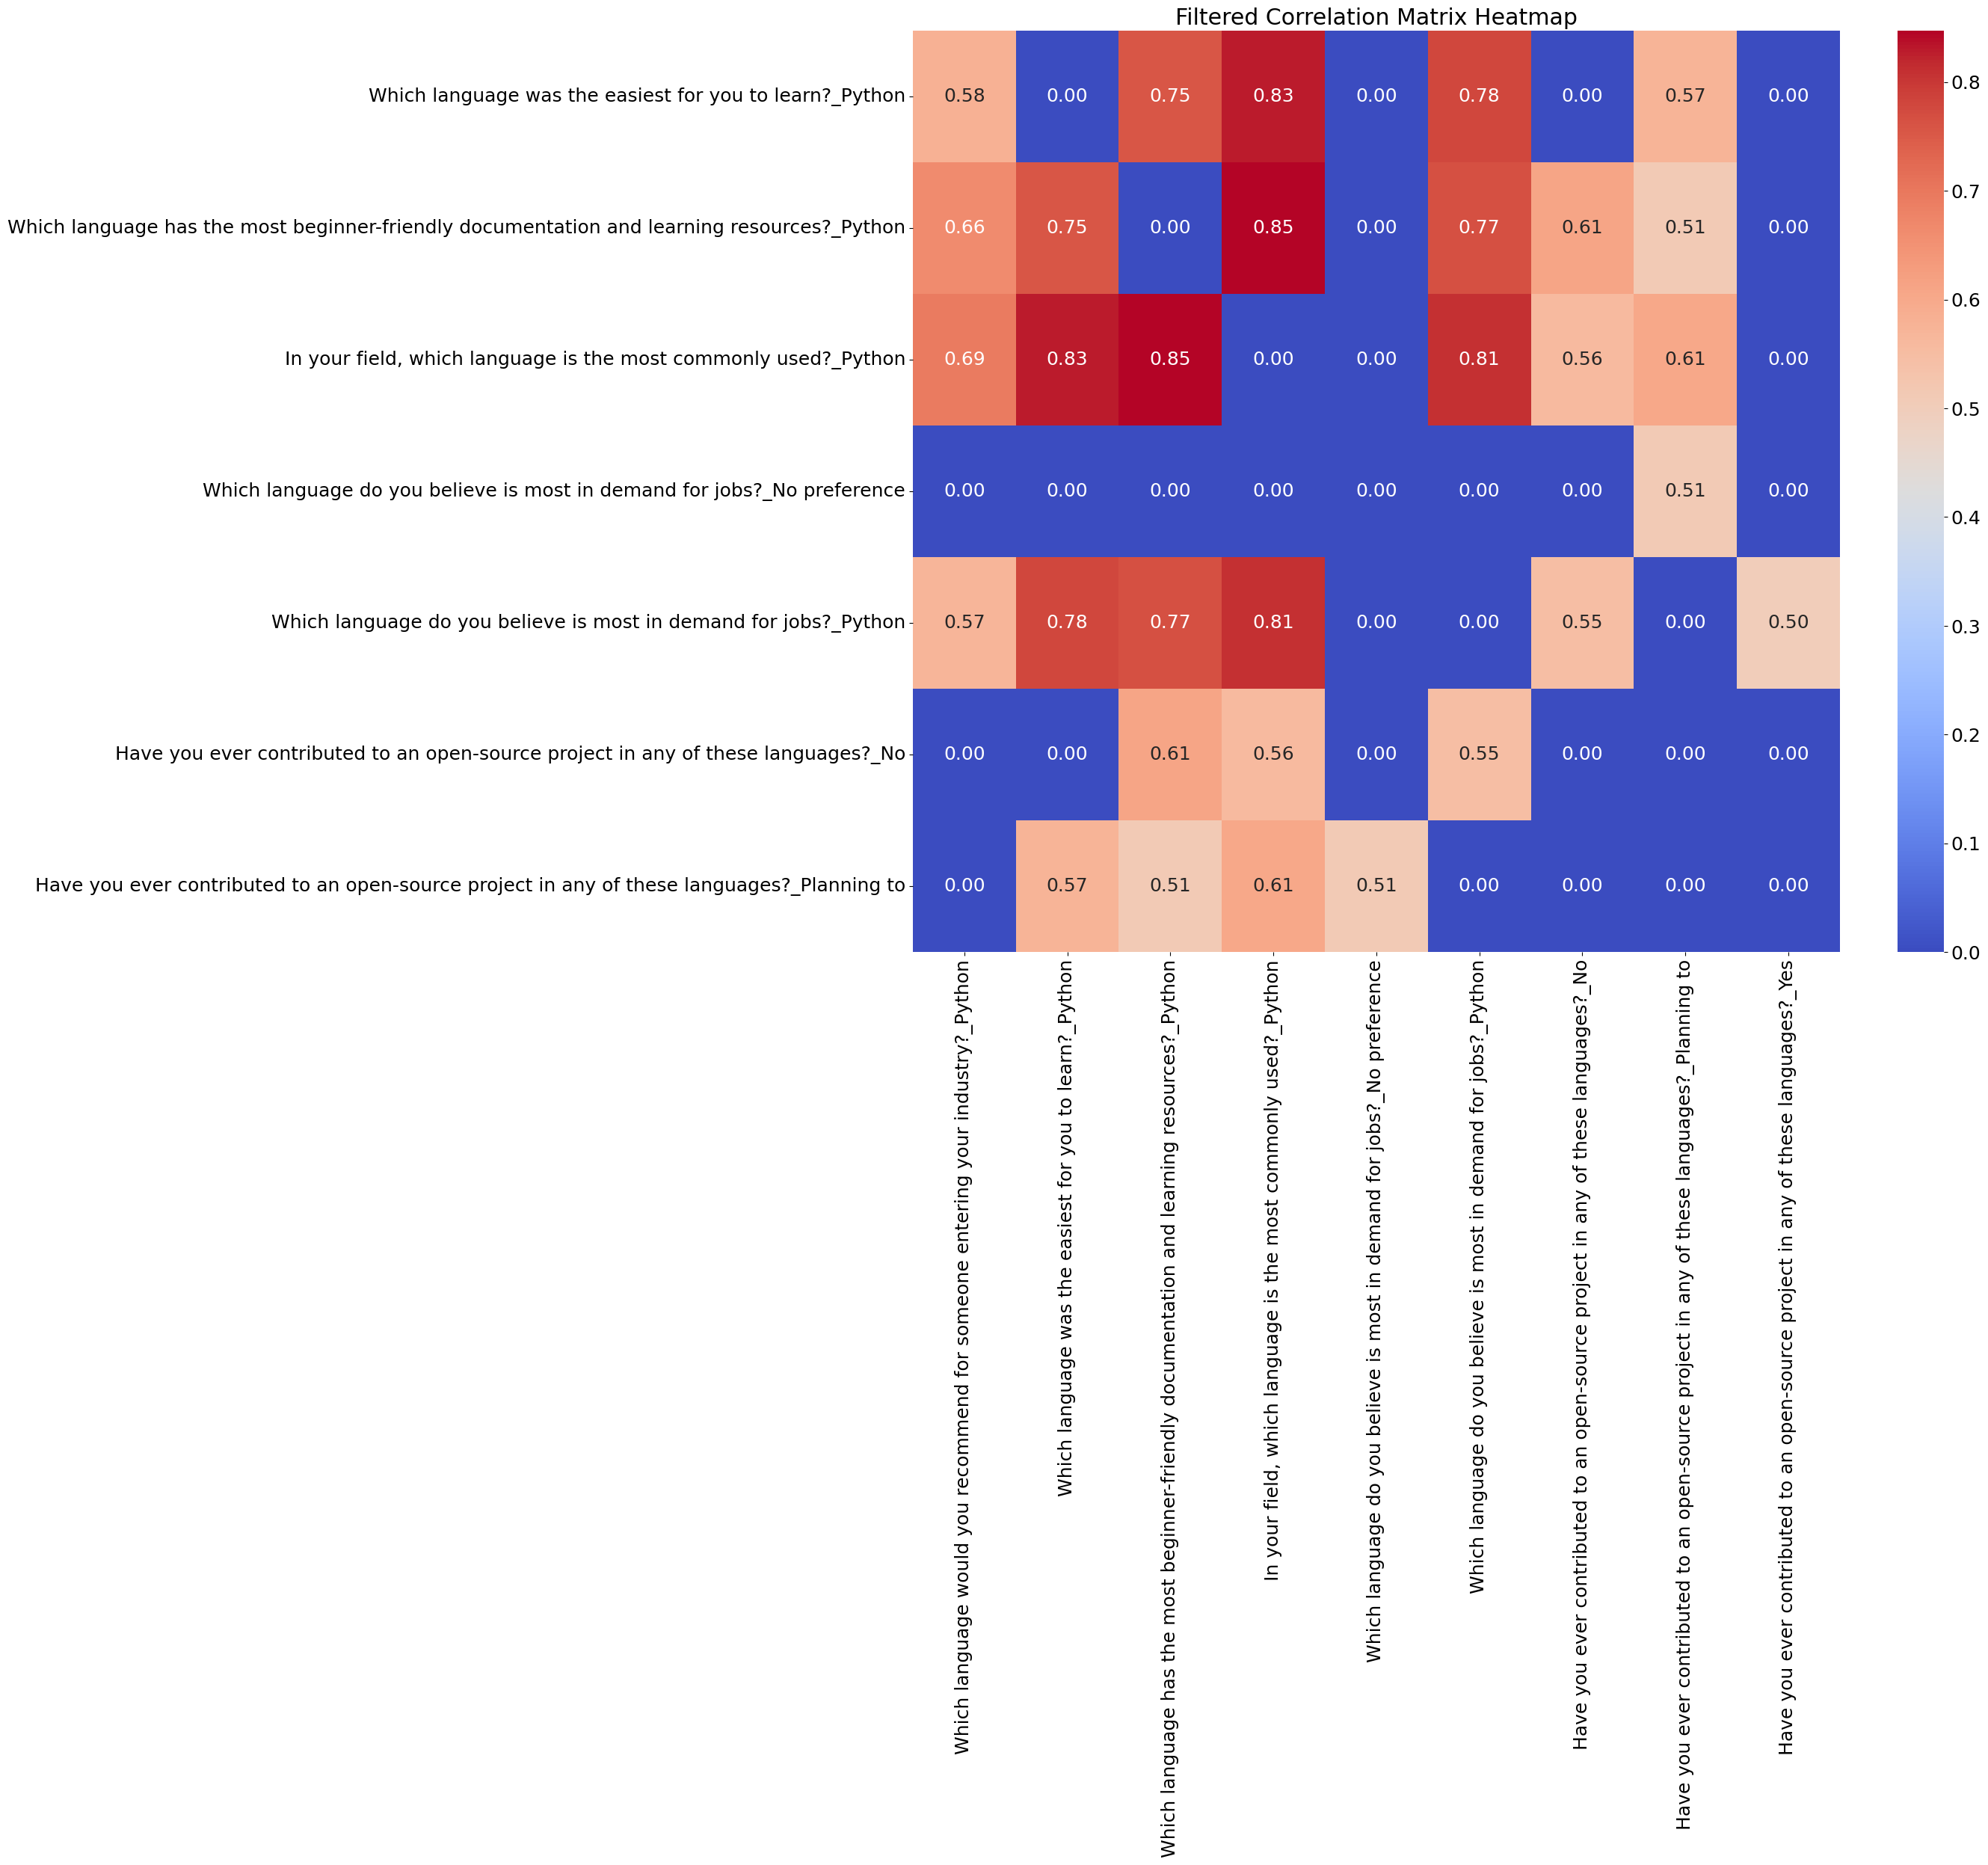

In [160]:
# Plot the heatmap
plt.figure(figsize=(20, 16))
plt.rcParams.update({'font.size': 18})
sns.heatmap(filtered_correlation_matrix.fillna(0), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Filtered Correlation Matrix Heatmap")
plt.show()